In [1]:
import torch
import monai
from monai.transforms import (
    Compose,
    EnsureChannelFirst,
    ScaleIntensity,
    Resize,
    LoadImage,
    RandRotate90,
    RandFlip,
    RandZoom,
    RandGaussianNoise,
    ToTensor,
    Lambda
)
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from torch.utils.tensorboard import SummaryWriter


# Set deterministic training for reproducibility
set_determinism(seed=0)

def rgb_to_grayscale(image):
    if image.shape[0] == 3:  # If it's an RGB image
        return torch.mean(image, dim=0, keepdim=True)
    return image  # If it's already grayscale, return as is

# Load and preprocess the image and corresponding mask
def preprocess_image(image_path, mask_path):
    # Define preprocessing transforms
    preprocess_image = Compose([
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        Resize((256, 256)),
        Lambda(rgb_to_grayscale),
        ToTensor()
    ])

    preprocess_mask = Compose([
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        Resize((256, 256)),
        Lambda(rgb_to_grayscale),
        ToTensor()
    ])

    image = preprocess_image(image_path)
    mask = preprocess_mask(mask_path)
    
    return image, mask

# Create a dataset for images and masks
class SimpleDataset(Dataset):
    def __init__(self, image_paths, mask_paths, is_training=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.is_training = is_training
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        return preprocess_image(self.image_paths[index], self.mask_paths[index])

# Set up the improved UNet model
def get_unet_model(in_channels=1, out_channels=1):  # Output is binary, so out_channels = 1
    return UNet(
        spatial_dims=2,
        in_channels=in_channels,
        out_channels=out_channels,
        channels=(32, 64, 128, 256, 512),
        strides=(2, 2, 2, 2),
        num_res_units=3,
        dropout=0.2
    )

# Training function
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = DiceLoss(sigmoid=True)  # Sigmoid activation for binary segmentation
    
    # Initialize SummaryWriter
    writer = SummaryWriter()
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_idx, batch_data in enumerate(train_loader):
            inputs, targets = batch_data[0].to(device), batch_data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
            # Log training loss every 10 batches
            if batch_idx % 10 == 0:
                writer.add_scalar('Training Loss', loss.item(), epoch * len(train_loader) + batch_idx)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_targets = val_data[0].to(device), val_data[1].to(device)
                val_outputs = model(val_inputs)
                val_loss += loss_function(val_outputs, val_targets).item()
        
        # Log average losses for the epoch
        writer.add_scalar('Average Training Loss', epoch_loss / len(train_loader), epoch)
        writer.add_scalar('Average Validation Loss', val_loss / len(val_loader), epoch)
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    writer.close()
    return model

/home/haiche/anaconda3/envs/haiche/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import random

# Define the paths for benign, malignant, and normal folders

benign_dir = "Dataset_BUSI_with_GT/benign"

malignant_dir = "Dataset_BUSI_with_GT/malignant"

normal_dir = "Dataset_BUSI_with_GT/normal"

 

# Get all image paths from benign, malignant, and normal directories

all_image_paths = []

 
# Get benign images

all_image_paths += [os.path.join(benign_dir, i) for i in os.listdir(benign_dir) if i.endswith(".png")]

 

# Get malignant images

all_image_paths += [os.path.join(malignant_dir, i) for i in os.listdir(malignant_dir) if i.endswith(".png")]

 

# Get normal images

all_image_paths += [os.path.join(normal_dir, i) for i in os.listdir(normal_dir) if i.endswith(".png")]

# Shuffle the list of all image paths
random.shuffle(all_image_paths)

# Split the shuffled list into train and validation sets (e.g., 80% train, 20% validation)
split_index = int(0.8 * len(all_image_paths))
train_paths = all_image_paths[:split_index]
val_paths = all_image_paths[split_index:]

# Separate masks and non-masks for training set
train_image_paths = [path for path in train_paths if "mask" not in path]
train_mask_paths = [path.replace(".png", "_mask.png") for path in train_image_paths]

# Separate masks and non-masks for validation set
val_image_paths = [path for path in val_paths if "mask" not in path]
val_mask_paths = [path.replace(".png", "_mask.png") for path in val_image_paths]


In [3]:
train_image_paths[300], train_mask_paths[300]

('Dataset_BUSI_with_GT/benign/benign (39).png',
 'Dataset_BUSI_with_GT/benign/benign (39)_mask.png')

In [4]:
batch_size = 32 * 2
train_dataset = SimpleDataset(train_image_paths, train_mask_paths, is_training=True)
val_dataset = SimpleDataset(val_image_paths, val_mask_paths, is_training=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# Initialize and train the model
model = get_unet_model()
num_epochs = 50
trained_model = train_model(model, train_loader, val_loader, num_epochs=num_epochs)

Epoch 1/50, Train Loss: 8.8299, Val Loss: 2.5984


In [3]:
torch.save(trained_model.state_dict(), 'unet_model.pth')
print("Model saved successfully.")

NameError: name 'trained_model' is not defined

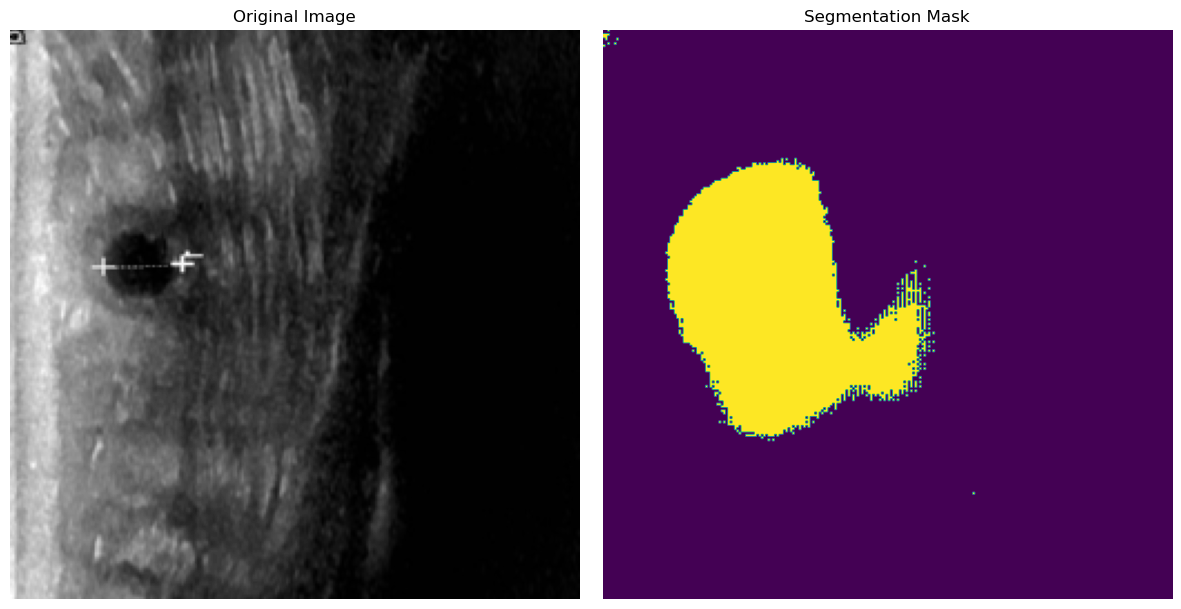

In [8]:
# Load and preprocess the test image
trained_model.eval()
def preprocess_single_image(image_path):
    preprocess = Compose([
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        Resize((256, 256)),
        Lambda(rgb_to_grayscale),
        ToTensor()
    ])
    return preprocess(image_path)

# Perform inference on a single image
def infer_single_image(model, image_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    # Preprocess the image
    test_image = preprocess_single_image(image_path)
    
    with torch.no_grad():
        test_input = test_image.unsqueeze(0).to(device)
        test_output = model(test_input)
        segmentation = torch.sigmoid(test_output).squeeze().cpu().numpy()
        segmentation = (segmentation > 0.5).astype(np.uint8)  # Apply threshold
    
    return test_image.squeeze().cpu().numpy(), segmentation

# Visualize results
def visualize_results(original_image, segmentation):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(segmentation, cmap='viridis')
    plt.title('Segmentation Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Usage example
test_image_path = "Dataset_BUSI_with_GT/benign/benign (433).png"
original_image, segmentation_mask = infer_single_image(trained_model, test_image_path)
visualize_results(original_image, segmentation_mask)

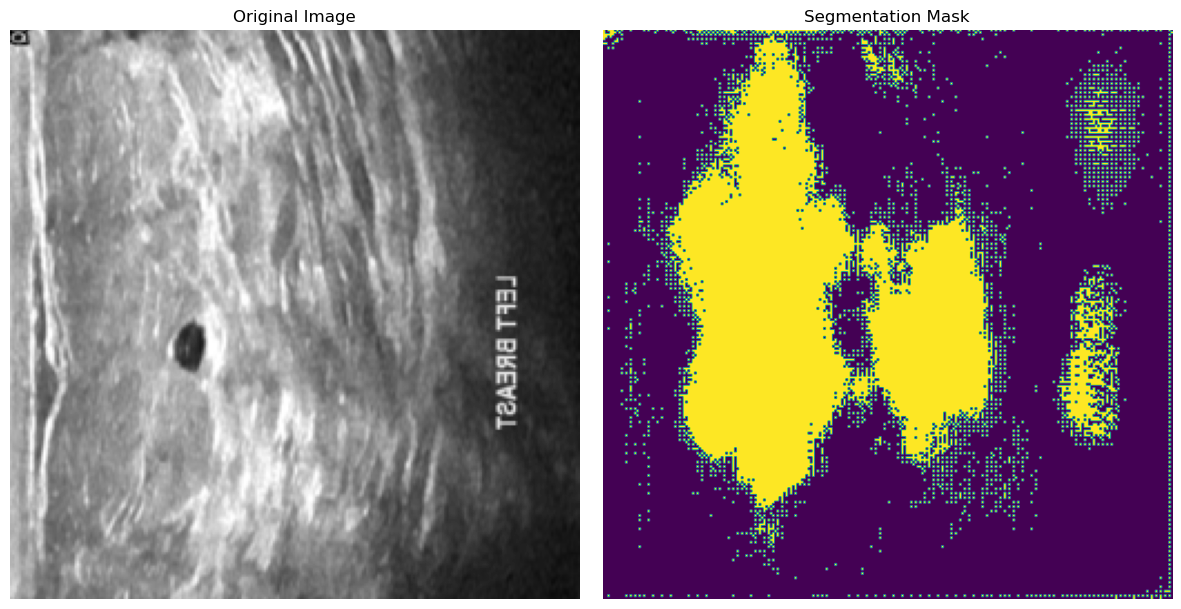

In [10]:
# Load and preprocess the test image
def preprocess_single_image(image_path):
    preprocess = Compose([
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        Resize((256, 256)),
        Lambda(rgb_to_grayscale),
        ToTensor()
    ])
    return preprocess(image_path)

# Perform inference on a single image
def infer_single_image(model, image_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    # Preprocess the image
    test_image = preprocess_single_image(image_path)
    
    with torch.no_grad():
        test_input = test_image.unsqueeze(0).to(device)
        test_output = model(test_input)
        segmentation = torch.sigmoid(test_output).squeeze().cpu().numpy()
        segmentation = (segmentation > 0.5).astype(np.uint8)  # Apply threshold
    
    return test_image.squeeze().cpu().numpy(), segmentation

# Visualize results
def visualize_results(original_image, segmentation):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(segmentation, cmap='viridis')
    plt.title('Segmentation Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Usage example
test_image_path = "Dataset_BUSI_with_GT/benign/benign (1).png"
original_image, segmentation_mask = infer_single_image(trained_model, test_image_path)
visualize_results(original_image, segmentation_mask)